# Plot diagrams


In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

In [9]:
metric_file_root_path = "../runs/"
x_value_order = ["1", "3", "10", "30", "All"]  # , "100"
x_axis_title = "N.o. samples per class"
y_axis_title = "Macro F1 score"
score_column = "f1_macro"

aggregating_configs = {
    "Random": r"(?i)random_.+",
    "ImageNet SL V1": r"(?i)imagenet_v1",
    "ImageNet SL V2": r"(?i)imagenet_v2",
    "ImageNet SL V3": r"(?i)imagenet_v3",
    "ImageNet SSL": r"(?i)imagenet_ssl",
    "PDDD": r"(?i)pddd.*",
}

architecture_configs = {
    "ResNet50": r"ResNet50",  #
    "ViT Base": r"ViT_B16",  #
}
model_configs = {
    "KNN": r"knn",  #
    "Linear regression": r"lr",  #
}
dataset_configs = {
    # "Cassava mini": r"Cassava_Mini-", #
    "PlantDoc": r"PlantDoc-",  #
    "Cassava": r"Cassava-",  #
    "PlantVillage": r"PlantVillage-",  #
}

In [3]:
def number_to_string(value):
    if value == value:
        return str(int(value))
    else:  # NaN
        return "All"


def distribution_check(configs, column):
    total_counter = 0
    for key in configs:
        name = configs[key]
        number_of_matching_rows = column.str.contains(name).sum()
        # print(f"{key} -> {number_of_matching_rows} matches")
        total_counter += number_of_matching_rows

    total_length = len(column)
    if total_length != total_counter:
        print(f"{total_length} != {total_counter}")
    # assert total_length == total_counter

Read 1312 entries in PlantDoc-metrics.txt
Read 1312 entries in Cassava-metrics.txt
Read 1312 entries in PlantVillage-metrics.txt


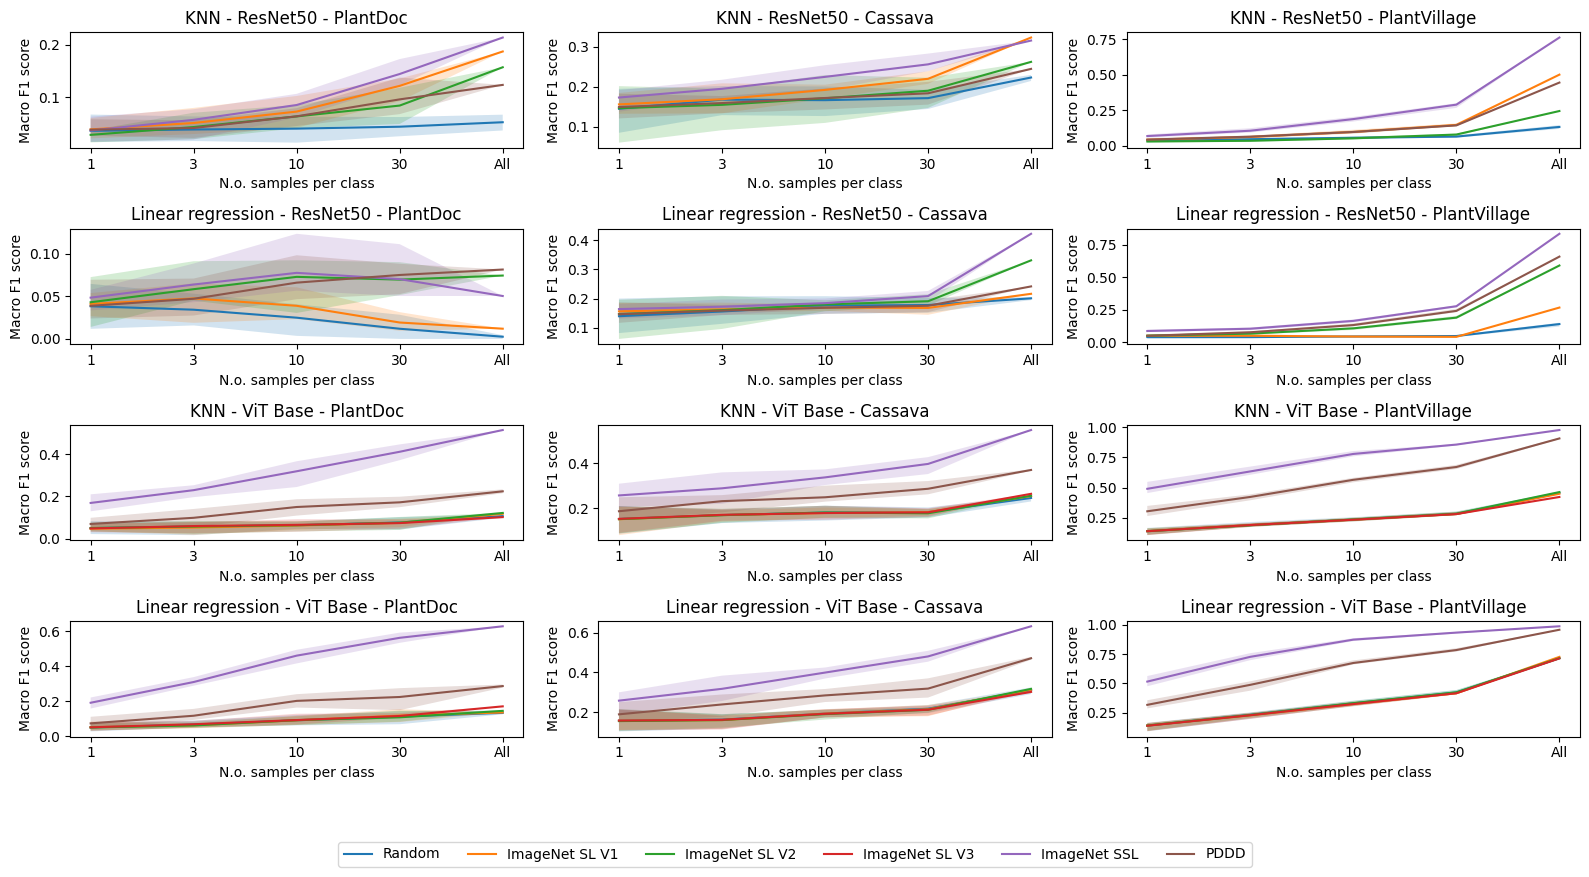

In [10]:
fig, ax = plt.subplots(
    len(architecture_configs) * len(model_configs),
    len(dataset_configs),
    figsize=(16, 8),
)

for column, dataset_key in enumerate(dataset_configs):
    dataset = dataset_configs[dataset_key]
    metric_file_name = f"{dataset}metrics.txt"
    metric_file = open(os.path.join(metric_file_root_path, metric_file_name), "r")
    content = metric_file.read().replace("\n", "").replace("}{", "},{")
    entries = json.loads("[" + content + "]")
    print(f"Read {len(entries)} entries in {metric_file_name}")
    df = pd.DataFrame.from_records(entries)

    distribution_check(model_configs, df["model_name"])
    distribution_check(dataset_configs, df["feature_identifier"])
    distribution_check(architecture_configs, df["feature_identifier"])
    distribution_check(aggregating_configs, df["feature_identifier"])

    df["number_of_samples"] = df["number_of_samples"].apply(number_to_string)
    df_data = df[df["feature_identifier"].str.contains(dataset)]  # not necessary

    for row_1, arch_key in enumerate(architecture_configs):
        architecture = architecture_configs[arch_key]
        df_arch = df_data[df_data["feature_identifier"].str.contains(architecture)]

        for label in aggregating_configs:
            df_agg = df_arch[
                df_arch["feature_identifier"].str.contains(aggregating_configs[label])
            ]

            for row_2, model_key in enumerate(model_configs):
                df_model = df_agg[
                    df_agg["model_name"].str.contains(model_configs[model_key])
                ]

                row = row_1 * len(model_configs) + row_2

                df_val = df_model.groupby(["number_of_samples"]).agg(
                    {"f1_macro": ["mean", "min", "max"]}
                )
                df_val.columns = df_val.columns.droplevel(0)
                df_val = df_val.reset_index()
                df_val.set_index("number_of_samples", inplace=True)
                df_val = df_val.reindex(index=x_value_order)

                ax[row][column].fill_between(
                    df_val.index, df_val["min"], df_val["max"], alpha=0.2
                )
                # ax[row][column].plot(df_val["mean"], linestyle='dashed',label=label) # ,label=[label]
                df_val.plot.line(
                    ax=ax[row][column],
                    y=["mean"],
                    # x=["number_of_samples"], NOTE: index is x-axis as default
                    label=[label],
                )

                # ax[row][column].set_ylim([0, 0.6])
                ax[row][column].set_title(f"{model_key} - {arch_key} - {dataset_key}")
                ax[row][column].set_ylabel(y_axis_title)
                ax[row][column].set_xlabel(x_axis_title)
                ax[row][column].get_legend().remove()

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines_labels = [fig.axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.tight_layout()
# fig.legend(lines, labels, loc='lower center', ncol=4)
fig.legend(
    lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(labels)
)
plt.show()

In [5]:
# ResNet Random_19 (K=1): 0.07036247334754797
# ResNet Random_20 (K=1): 0.053304904051172705
# ResNet Random_21 (K=1): 0.07462686567164178
# ResNet ImageNet_v1 (K=1): 0.15565031982942432
# ResNet ImageNet_v2 (K=1): 0.10660980810234541
# ResNet PDDD (K=1): 0.18976545842217485

# Swin_T Random_19 (K=1): 0.06823027718550106
# Swin_T Random_20 (K=1): 0.0767590618336887
# Swin_T Random_21 (K=1): 0.05543710021321962
# Swin_T ImageNet (K=1): 0.39872068230277186
# Swin_T PDDD (K=1): 0.2579957356076759

# ResNet Random_19: 0.0021321961620469083
# ResNet Random_20: 0.01279317697228145
# ResNet Random_21: 0.008528784648187633 ???
# ResNet ImageNet_v1: 0.008528784648187633 ???
# ResNet ImageNet_v2: 0.07889125799573561
# ResNet PDDD: 0.14285714285714285

# Swin_T Random_19: 0.1023454157782516
# Swin_T Random_20: 0.10660980810234541
# Swin_T Random_21: 0.12366737739872068
# Swin_T ImageNet: 0.5778251599147122
# Swin_T PDDD: 0.3411513859275053

x_values_random = [
    "KNN ResNet50",
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "KNN Swin-T",
    "KNN Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
]
y_values_random = [
    0.07036247334754797,
    0.053304904051172705,
    0.07462686567164178,
    0.0021321961620469083,
    0.01279317697228145,
    0.008528784648187633,
    0.06823027718550106,
    0.0767590618336887,
    0.05543710021321962,
    0.1023454157782516,
    0.10660980810234541,
    0.12366737739872068,
]
x_values_imagenet = [
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_imagenet = [
    0.15565031982942432,
    0.10660980810234541,
    0.008528784648187633,
    0.07889125799573561,
    0.39872068230277186,
    0.5778251599147122,
]
x_values_pddd = [
    "KNN ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_pddd = [
    0.18976545842217485,
    0.14285714285714285,
    0.2579957356076759,
    0.3411513859275053,
]

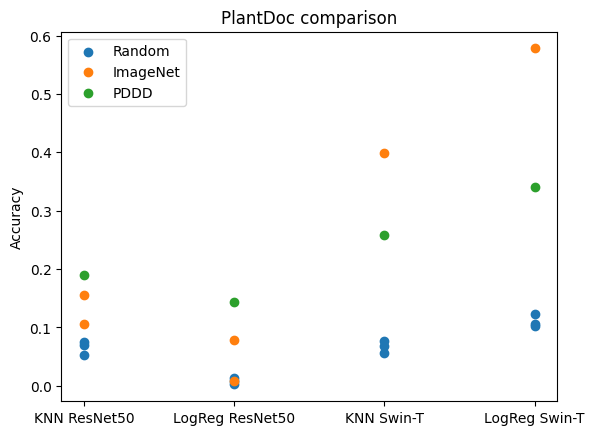

In [6]:
plt.scatter(x_values_random, y_values_random)
plt.scatter(x_values_imagenet, y_values_imagenet)
plt.scatter(x_values_pddd, y_values_pddd)
plt.gca().set_ylabel("Accuracy")  # gca = get current axes
plt.legend(["Random", "ImageNet", "PDDD"])
plt.title("PlantDoc comparison")
plt.show()

In [7]:
x_values_random = [
    "KNN ResNet50",
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "KNN Swin-T",
    "KNN Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
]
y_values_random = [
    0.446064139941691,
    0.43440233236151604,
    0.43440233236151604,
    0.2944606413994169,
    0.32653061224489793,
    0.40233236151603496,
    0.45481049562682213,
    0.36151603498542273,
    0.40233236151603496,
    0.5451895043731778,
    0.4752186588921283,
    0.4956268221574344,
]
x_values_imagenet = [
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_imagenet = [
    0.5714285714285714,
    0.565597667638484,
    0.2565597667638484,
    0.4897959183673469,
    0.5830903790087464,
    0.7346938775510204,
]
x_values_pddd = [
    "KNN ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_pddd = [
    0.4752186588921283,
    0.42565597667638483,
    0.6122448979591837,
    0.6384839650145773,
]

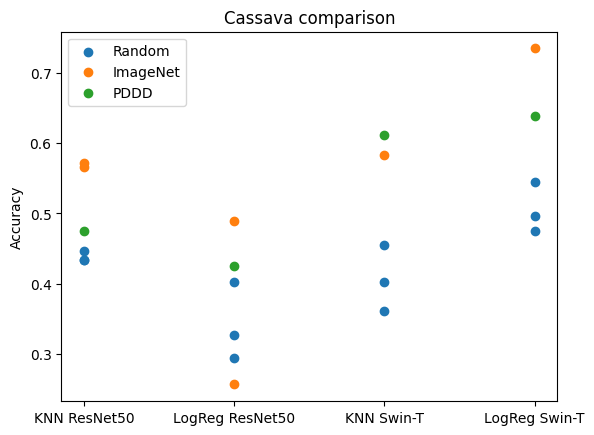

In [8]:
plt.scatter(x_values_random, y_values_random)
plt.scatter(x_values_imagenet, y_values_imagenet)
plt.scatter(x_values_pddd, y_values_pddd)
plt.gca().set_ylabel("Accuracy")  # gca = get current axes
plt.legend(["Random", "ImageNet", "PDDD"])
plt.title("Cassava comparison")
plt.show()